<a href="https://colab.research.google.com/github/jeetintyagi/BTC-Data-Analysis-binanceAPI/blob/main/BTC_LSTM_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



 ## Getting dependencies ready




In [1]:
%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
%matplotlib inline

### We are using **cryptocompare API** to get the *BTC OHLCV* data for our LSTM model
### The response we get form the API is in json format.
### so we load only the *BTCUSD* last **1000 day** OHLCV data from the API.

```python
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=1000')
# fsym = BTC means bitcoin cryptocurrency
# limit = 1000 means last 1000 day data
# tsym = USD means USD pair of BTC
```

### And convert the **json data** into pandas data-frame with time as index

```python
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
```

In [2]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=1000')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'
hist.head(10)

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2019-07-10,13183.73,11569.94,12567.02,124523.09,1.554955e+09,12099.12,direct,
2019-07-11,12099.91,11002.39,12099.12,102929.11,1.185222e+09,11343.12,direct,
2019-07-12,11931.91,11096.61,11343.12,55994.89,6.476901e+08,11797.37,direct,
2019-07-13,11835.87,10827.53,11797.37,59187.84,6.683252e+08,11363.97,direct,
2019-07-14,11447.92,10118.85,11363.97,76310.21,8.146678e+08,10204.41,direct,
2019-07-15,11070.18,9877.02,10204.41,92742.77,9.651783e+08,10850.26,direct,
2019-07-16,11025.76,9366.82,10850.26,113537.84,1.140138e+09,9423.44,direct,
2019-07-17,9982.24,9086.51,9423.44,101032.08,9.652568e+08,9696.15,direct,
2019-07-18,10776.54,9292.61,9696.15,102443.07,1.033843e+09,10638.35,direct,


<hr>

### Dropping the **conversionType & conversionSymbol** columns from the dataframe
#### Setting columns as axis and u can see the change in the above and below 
#### dataframes and can tell which one is more cleaner & enough for the **LSTM model**



In [3]:
hist.drop(["conversionType", "conversionSymbol"], axis='columns', inplace=True)
hist.head(10)


,high,low,open,volumefrom,volumeto,close
time,,,,,,
2019-07-10,13183.73,11569.94,12567.02,124523.09,1.554955e+09,12099.12
2019-07-11,12099.91,11002.39,12099.12,102929.11,1.185222e+09,11343.12
2019-07-12,11931.91,11096.61,11343.12,55994.89,6.476901e+08,11797.37
2019-07-13,11835.87,10827.53,11797.37,59187.84,6.683252e+08,11363.97
2019-07-14,11447.92,10118.85,11363.97,76310.21,8.146678e+08,10204.41
2019-07-15,11070.18,9877.02,10204.41,92742.77,9.651783e+08,10850.26
2019-07-16,11025.76,9366.82,10850.26,113537.84,1.140138e+09,9423.44
2019-07-17,9982.24,9086.51,9423.44,101032.08,9.652568e+08,9696.15
2019-07-18,10776.54,9292.61,9696.15,102443.07,1.033843e+09,10638.35


# **Splitting of dataset into** : 

1.   Training dataset
2.   Testing dataset

###  **train** - training dataset
###  **test** - testing dataset

##### "***test_size = 0.2***" means **20%** of the dataset is for testing purpose 
##### and rest **80%** is for training the LSTM model.
<hr>

### Here, we wrote the function to split the dataset into
### training and testing datset with 2 parameters:

1.   **dataframe** to split 
2.   **test_size** (with default value of 0.2)

### Here is the function definition :
```python
def train_test_split(df, test_size=0.2):
```
this function returns the dataset as **train_data (initial 80%)** & 
**test_data (20%)**

```javascript
return train_data, test_data

```

In [4]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

# calling the function and storing the splitted dataset
# into train and test variables 
train, test = train_test_split(hist, test_size=0.2)


In [5]:
train

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2019-07-10,13183.73,11569.94,12567.02,124523.09,1.554955e+09,12099.12
2019-07-11,12099.91,11002.39,12099.12,102929.11,1.185222e+09,11343.12
2019-07-12,11931.91,11096.61,11343.12,55994.89,6.476901e+08,11797.37
2019-07-13,11835.87,10827.53,11797.37,59187.84,6.683252e+08,11363.97
2019-07-14,11447.92,10118.85,11363.97,76310.21,8.146678e+08,10204.41
...,...,...,...,...,...,...
2021-09-13,46821.84,43511.30,46049.72,42623.67,1.909473e+09,44958.56
2021-09-14,47263.56,44776.37,44958.56,26751.25,1.237184e+09,47129.01
2021-09-15,48457.30,46725.15,47129.01,26904.97,1.282943e+09,48148.45


In [6]:
test

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2021-09-18,48808.00,47066.47,47297.98,15782.18,7.610798e+08,48312.46
2021-09-19,48376.30,46864.50,48312.46,14044.93,6.687233e+08,47251.76
2021-09-20,47340.49,42552.63,47251.76,64374.41,2.849781e+09,42925.46
2021-09-21,43625.93,39767.17,42925.46,70924.75,2.972566e+09,40709.59
2021-09-22,44012.22,40589.07,40709.59,42391.10,1.807577e+09,43576.15
...,...,...,...,...,...,...
2022-04-01,46726.20,44256.66,45522.65,34247.82,1.558892e+09,46299.75
2022-04-02,47208.84,45655.15,46299.75,16494.27,7.658498e+08,45822.28
2022-04-03,47432.60,45565.57,45822.28,17415.21,8.098194e+08,46414.26


<hr>

Function to plot the line chart for **BTCUSD** :
- differentiating the training and testing data for our LSTM model 
- on daily timeframe squeezed as per the weekly timeframe chart 


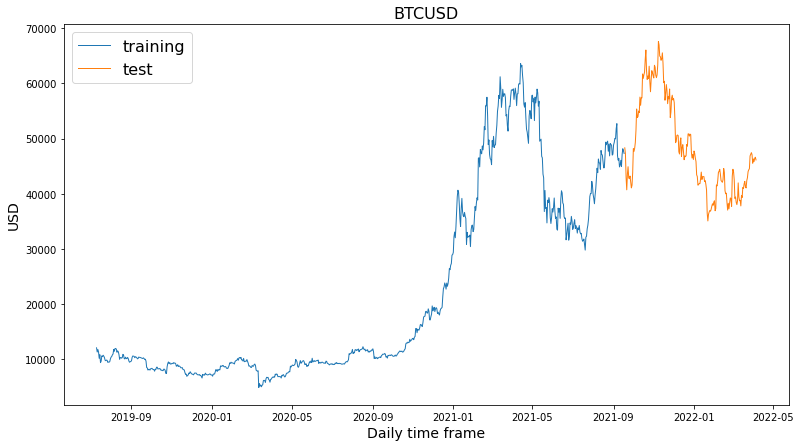

In [7]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('USD', fontsize=14)
    ax.set_xlabel('Daily time frame', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)


line_plot(train[target_col], test[target_col], 'training', 'test', title='BTCUSD',lw =1)


In [8]:

def normalise_zero_base(df):
    return df / df.iloc[0] - 1


In [9]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)


In [10]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test


In [11]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(
        input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model


In [12]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'


In [13]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)


Epoch 1/20
25/25 [==============================] - 4s 58ms/step - loss: 0.0053 - val_loss: 0.0027
Epoch 2/20
25/25 [==============================] - 0s 13ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 3/20
25/25 [==============================] - 0s 12ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 4/20
25/25 [==============================] - 0s 12ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 5/20
25/25 [==============================] - 0s 16ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 6/20
25/25 [==============================] - 0s 15ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 7/20
25/25 [==============================] - 0s 11ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 8/20
25/25 [==============================] - 0s 10ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 9/20
25/25 [==============================] - 0s 11ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 10/20
25/25 [==============================] - 0s 13ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 11/

# Line chart of **Epochs vs MSE**

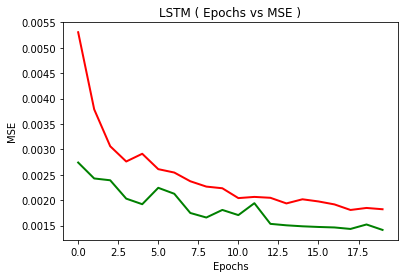

In [14]:
plt.plot(history.history['loss'], 'r', linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',
         linewidth=2, label='Validation loss')
plt.title('LSTM ( Epochs vs MSE )')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()


# Mean Absolute Error

In [15]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)


0.02775645505181942

# Mean Squared Error

In [16]:
MSE = mean_squared_error(preds, y_test)
MSE


0.0014148838889037716

<hr>

### **R2 score** is used to evaluate the performance of a regression-based machine learning model.
### Also known as the ***coefficient of determination***. It works by measuring the amount of variance in the predictions explained by the dataset.
### In other fields, the standards for a good R-Squared reading can be much higher, such as **0.9 or above**. 
### In finance, an R-Squared **above 0.7** would generally be seen as showing a high level of correlation whereas a measure **below 0.4** would show a low correlation.

### R2 score using plain python :

```python
print ("total sum of squares", y)
print ("ẗotal sum of residuals ", g)
print ("r2 calculated", 1 - (g / y))

# where g is the sum of the differences between the observed values and the 
# predicted ones. (ytest[i] – preds[i]) **2. y is each observed value y[i] 
# minus the average of observed values np.mean(ytest).
```
### We can ofcourse let scikit-learn to do this with its S2_score() method:

```python
print("R2 score : %.2f" % r2_score(ytest,preds))
```
which we have implemented in our LSTM model  

In [17]:
R2 = r2_score(y_test, preds)
R2


0.7433056174255344

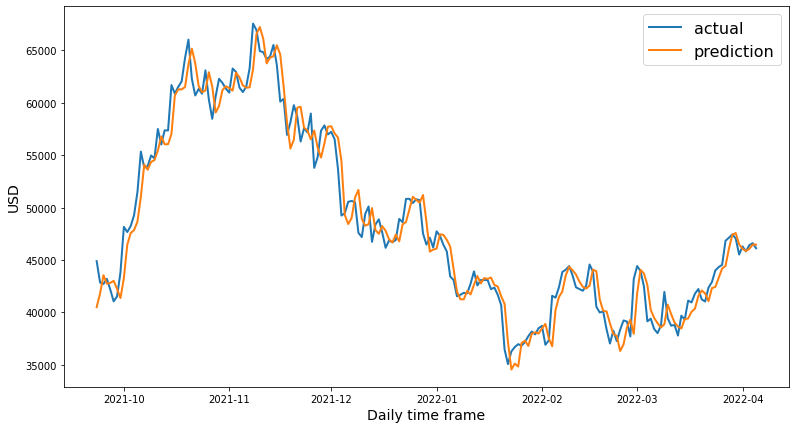

In [18]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=2)


In [19]:
# !wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
# from colab_pdf import colab_pdf
# colab_pdf('BTC_LSTM_MODEL.ipynb')